# Modelo baseado em dados para estimativas da dinâmica epidêmica da COVID19

 Referências: <br>
 
 [1] https://scikit-learn.org/stable/modules/gaussian_process.html <br>
 [2] https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 <br>
 [3] RW2006(1,2,3,4,5,6) Carl Eduard Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006, http://www.gaussianprocess.org/gpml/chapters/RW.pdf<br>




In [6]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

### Importa os dados

In [7]:
data = scipy.io.loadmat('cumCasesPB.mat')['cumCasesPB']

trainL = 132 # número de dias  a partir do dia 1 utilizado como conjunto de treinamento
Ndias = 3    # intervalo de média móvel

# calcula média móvel dos dados
data  = np.reshape(data, data.size)
movAvFilter = np.ones(Ndias)/Ndias
movAvFilter = np.reshape(movAvFilter, movAvFilter.size)
data = signal.lfilter(movAvFilter, 1, data)

# escalona valores por milhares
CRdata = data/1000     
DRdata = np.diff(data.transpose())
DRdata = DRdata.transpose()/1000


Text(0.5, 1.0, 'COVID-PB')

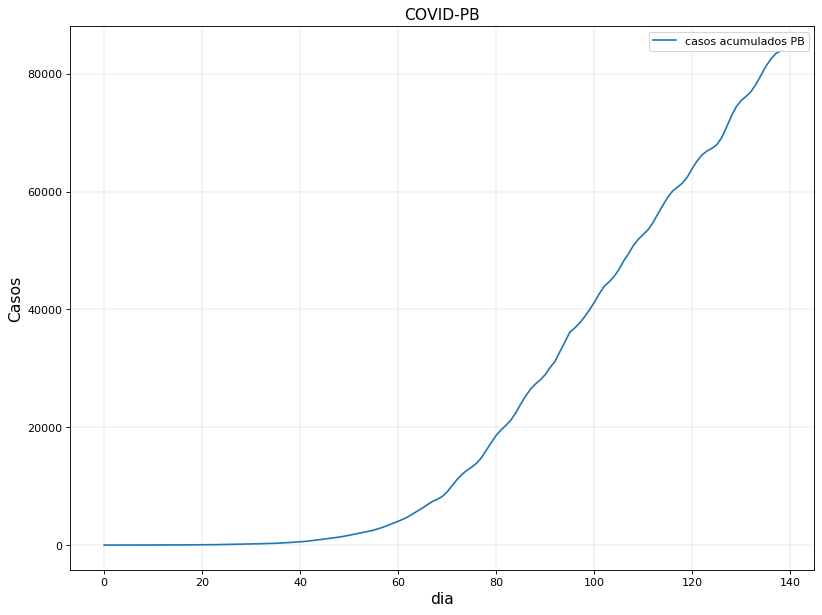

In [8]:
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data)
plt.legend(['casos acumulados PB'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

### Modelagem GPR para o número de casos acumulados


Learned kernel: 135**2 * Matern(length_scale=449, nu=1.5)

MSE: 83567.643978

STD: 289.080688


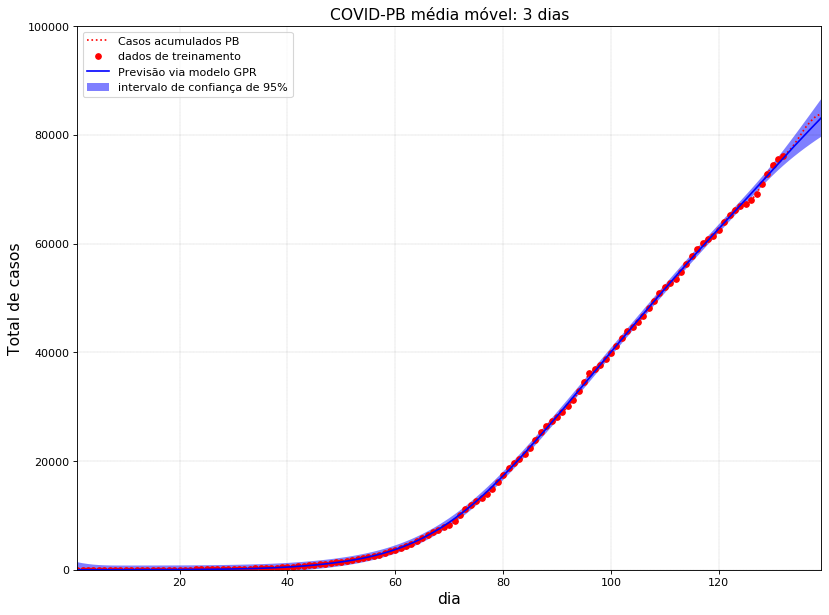

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, WhiteKernel, Matern

# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(CRdata),1)
t = np.atleast_2d(t)

CRdata  = np.ravel(CRdata)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
CR_tr = CRdata[0:trainL]

# Define kernel a ser utilizado
kernel = ConstantKernel()* Matern(1.0)

# Instancia classe GPR
model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 2, normalize_y=False)

# Treinamento do modelo
model.fit(t_tr, CR_tr)
print("\nLearned kernel: %s" % model.kernel_)
params = model.kernel_.get_params()

CRpred_, sigma = model.predict(t_tr, return_std=True) # previsão dos intervalo de treinamento
CRpred, sigma = model.predict(t, return_std=True)     # previsão para todo o intervalo de dados

# Plota resultados
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, CRdata*1000, 'r:', label=r'Casos acumulados PB')
plt.plot(t_tr, CR_tr*1000, 'r.', markersize=10, label='dados de treinamento')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                        (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left')
plt.ylim(0, 100e3)
plt.xlim(1, np.size(CRdata))
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB média móvel: %d dias' %Ndias, fontsize = 14)

MSE = np.mean(((CRpred_-CR_tr)*1000)**2)
print("\nMSE: %f" % MSE)
print("\nSTD: %f" % np.sqrt(MSE))

### Modelagem GPR para número de novos casos diários

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, WhiteKernel, RationalQuadratic


# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(DRdata),len(DRdata))
t = t.reshape(len(DRdata),1)
t = np.atleast_2d(t)
DRdata  = np.ravel(DRdata)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
DR_tr = DRdata[0:trainL]

# Define kernel a ser utilizado
kernel = ConstantKernel()* Matern(1.0, nu=1.5) + ConstantKernel()* Matern(1.0, nu=1.5) * ExpSineSquared(length_scale=1.44, periodicity=7)

# Instancia classe GPR
model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200, alpha = 0.1, normalize_y=False)

# Treinamento do modelo
model.fit(t_tr, DR_tr)
print("\nParâmetros do kernel após treinamento: %s" % model.kernel_)
params = model.kernel_.get_params()

DRpred_, sigma = model.predict(t_tr, return_std=True) # previsão dos intervalo de treinamento
DRpred, sigma  = model.predict(t, return_std=True)    # previsão para todo o intervalo de dados

# Plota resultados
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, DRdata*1000, 'r:', label=r'Casos diários PB')
plt.plot(t_tr, DR_tr*1000, 'r.', markersize=10, label='dados de treinamento')
plt.plot(t, DRpred*1000, 'b-', label='Previsão via modelo GPR')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([DRpred*1000 - 1.9600 * 1000*sigma,
                        (DRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.xlabel('$t$')
plt.ylabel('$Número de casos diários$')
plt.legend(loc='upper left')
plt.ylim(0, 2e3)
plt.xlim(0, np.size(DRdata))
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos diários', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB média móvel: %d dias' %Ndias, fontsize = 14)

MSE = np.mean(((DRpred_-DR_tr)*1000)**2)
print("\nMSE treinamento: %f" % MSE)
print("\nSTD treinamento: %f" % np.sqrt(MSE))